## 06 - Exercise 2

In [2]:
# Setup imports
import tensorflow as tf

In [3]:
# Setup train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [4]:
# Setup the base model and freeze its layers (this will extract features)
IMG_SHAPE = IMG_SIZE + (3,)
input_shape = IMG_SHAPE
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
# x = data_augmentation(inputs)  # Augment images (only happens during training phase)
x = base_model(inputs, training=False)  # Put the base model in inference mode so weights which need to stay frozen, stay frozen
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),
                                    activation="softmax",
                                    name="output_layer")(x)

# Make a model using the inputs and outputs
model = tf.keras.Model(inputs, outputs)

In [5]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [6]:
# Feature extract for 10 full passes and validate on 15% of the test data, to save epoch time
INITIAL_EPOCHS = 10

history = model.fit(train_data_all_10_percent,
                    epochs=INITIAL_EPOCHS,
                    steps_per_epoch=len(train_data_all_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 32s 97ms/step - loss: 3.0725 - accuracy: 0.3430 - val_loss: 2.3274 - val_accuracy: 0.4881
Epoch 2/10
237/237 [==============================] - 22s 92ms/step - loss: 1.7513 - accuracy: 0.6049 - val_loss: 1.9153 - val_accuracy: 0.5320
Epoch 3/10
237/237 [==============================] - 22s 92ms/step - loss: 1.3467 - accuracy: 0.6933 - val_loss: 1.7725 - val_accuracy: 0.5485
Epoch 4/10
237/237 [==============================] - 22s 92ms/step - loss: 1.1067 - accuracy: 0.7527 - val_loss: 1.7119 - val_accuracy: 0.5530
Epoch 5/10
237/237 [==============================] - 22s 91ms/step - loss: 0.9358 - accuracy: 0.8022 - val_loss: 1.6516 - val_accuracy: 0.5683
Epoch 6/10
237/237 [==============================] - 22s 91ms/step - loss: 0.8009 - accuracy: 0.8389 - val_loss: 1.6421 - val_accuracy: 0.5707
Epoch 7/10
237/237 [==============================] - 22s 92ms/step - loss: 0.6931 - accuracy: 0.8660 - val_loss: 1.6219 - val_accuracy:

In [7]:
# Evaluate on the whole test dataset
# Fine-tuning got: [1.5379085540771484, 0.5954851508140564]
# Loaded model: [1.8021461963653564, 0.6078416109085083]
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 49s 61ms/step - loss: 1.3695 - accuracy: 0.6335


[1.3695085048675537, 0.6334653496742249]

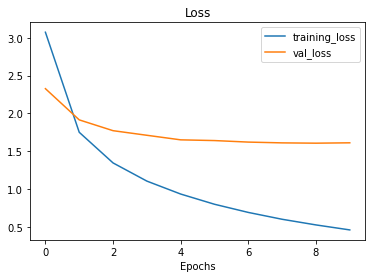

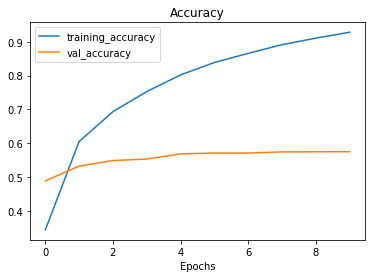

In [8]:
# Plot loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history)

Seems slightly better than the fine-tuning model, but for this mnodel I didn't use any data augmentation. Also this model seems to be overfitting more.

Let's test it on some images.

In [9]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    specified shape (img_shap, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        img_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image tensor
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale image if needed
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.

    return img

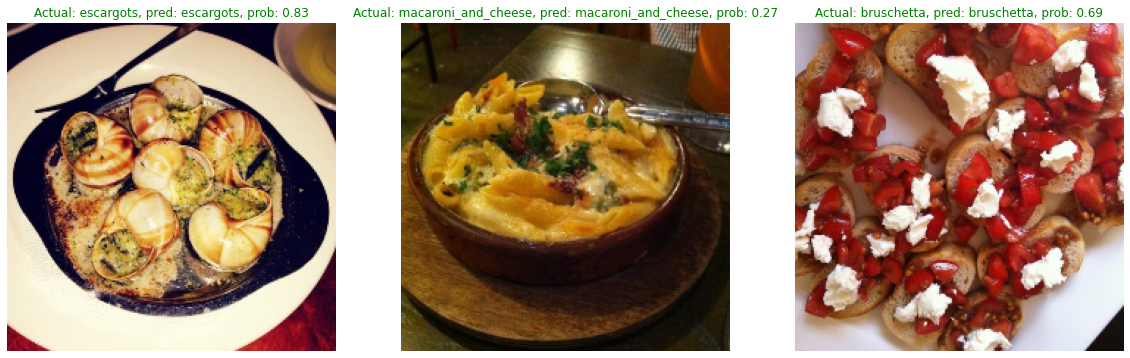

In [15]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(3):
    # Choose random a image from a random class
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded, verbose=0)  # get prediction probabilities array
    pred_class = test_data.class_names[pred_prob.argmax()]  # get highest prediction probability index

    # Plot the image
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:  # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)

## 06 - Exercise 3

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
# Recreate the model with mixed_precision
# policy = tf.keras.mixed_precision.Policy("mixed_float16")  # Seems like EfficientNetBx has a problem with mixed_precision
policy = tf.keras.mixed_precision.Policy("float32")
tf.keras.mixed_precision.set_global_policy(policy)

In [28]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


In [29]:
IMG_SHAPE = IMG_SIZE + (3,)
input_shape = IMG_SHAPE
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
# x = data_augmentation(inputs)  # Augment images (only happens during training phase)
x = base_model(inputs, training=False)  # Put the base model in inference mode so weights which need to stay frozen, stay frozen
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),
                                    activation="softmax",
                                    name="output_layer")(x)

# Make a model using the inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)